In [22]:
import math
from math import gcd
import numpy as np
import itertools
import csv
import matplotlib.pyplot as plt

In [23]:
class TaskSet:
    
    
    def __init__(self):
        
        # Initializing empty local array of tasks array
        self.__tasks = []

        
    def addTask(self, period, deadline, computeTime, phase):
        
        # Adding a task to the array of tasks
        self.__tasks.append({'period': period, 'deadline': deadline, 'computeTime': computeTime, 'phase': phase})

        
    def removeTask(self, index):
        
        # Deleting a task at index
        del self.__tasks[index]

        
    def getTask(self, index):
        
        # Return a task at certain index
        return self.__tasks[index]

    
    def getAllTasks(self):
        
        # Return all tasks
        return self.__tasks

    
    def size(self):
        
        # Returns number of tasks in the taskset
        return len(self.__tasks)
    
    
    def updatePhases(self, phase_array):
        
        # Updating phases of all tasks
        for i in range(len(phase_array)):
            self.__tasks[i]['phase'] = phase_array[i]

            
            

In [147]:
class CyclicExecutiveSchedule:
    
    
    def __init__(self, task_set):
        
        # Creating local copy of task_set object
        self.task_set = task_set
        
        # Calculating hyperperiod for the given task_set
        self.hyperperiod = self.compute_hyperperiod()
        
        # Cacluating all valid frame sizes
        self.valid_frames = self.compute_valid_frames()
        
        # Making an array of periods of all tasks in the taskset
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        
        # Making an array of compute times of all tasks in the taskset
        compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
        
        # Computing utilization factor
        self.utilization = 0
        for i in range(len(compute_times)):
            self.utilization += (compute_times[i] / periods[i])
        
        # Basic check that utilization factor does not exceed 100%, otherwise give warning
        if self.utilization>1:
            print("Utilization is "+str(self.utilization*100)+" % and It cannot be scheduled.")
        
        
    def compute_hyperperiod(self):
        
        # Making an array of periods of all tasks in the taskset
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        
        # Returning hyperperiod of all tasks in the taskset
        return math.lcm(*periods)

    
    def compute_valid_frames(self):
        
        # Making an array of periods of all tasks in the taskset
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        
        # Making an array of compute times of all tasks in the taskset
        compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
        
        # Finding out the minimum time period of a task in the taskset
        min_period = min(periods)
        
        # Finding out the maximum time period of a task in the taskset
        max_compute = max(compute_times)
        
        # Making an array of valid frame sizes
        self.valid_frames = []
        #print("Min period is: "+str(min_period))
        #print("\n")
        #print("Max compute is :"+str(max_compute))
        #print("\n")
        
        # Adding valid frame sizes to the array of valid frames after meeting the criteria
        for frame_size in range(max_compute, min_period+1):
            if (frame_size >= max_compute)and(frame_size <= min_period)and(self.hyperperiod % frame_size == 0):
                is_valid = True
                for task in self.task_set.getAllTasks():
                    period = task['period']
                    deadline = task['deadline']
                    gcd_val = gcd(period, frame_size)
                    frame_gcd = 2 * frame_size - gcd_val
                    if frame_gcd > deadline:
                        is_valid = False
                        break
                if is_valid:
                    self.valid_frames.append(frame_size)
        self.valid_frames = list(set(self.valid_frames))
        
        # Returing valid frames array
        return self.valid_frames
    
    
    def generate_combinations(self, numbers, target_sum, required_numbers):
        
        ## This is a helping function that helps in scheduling more than one tasks in one frame ##
        
        # This function takes numbers like [1 7 2 3 4] and required_numbers [7]
        # Generates a combination of numbers that should be less than or equal to target_sum like 10
        # Combination should not miss required_numbers and ignores in case of empty
        # Combination should be as diverse as possible that target_sum should be sum as many members of the set as possible
        # Combination for this case would be [7 1 2] not like [7 3] because of less diversity or [1 2 3 4] because [7] is required
        
        result = []
        max_combination = ()
        max_num_unique_elements = 0
        
        for r in range(1, len(numbers) + 1):
            combinations = itertools.combinations(numbers, r)
            for combination in combinations:
                if all(num in combination for num in required_numbers):
                    current_sum = sum(combination)
                    if current_sum <= target_sum:
                        num_unique_elements = len(set(combination))
                        if num_unique_elements > max_num_unique_elements:
                            max_num_unique_elements = num_unique_elements
                            max_combination = combination
                        elif num_unique_elements == max_num_unique_elements and len(combination) > len(max_combination):
                            max_combination = combination
        return max_combination if max_combination else "Cannot be done"
    
    
    def get_matching_numbers(self, number_mask, number_array):
        
        ## This is a helping function
        
        # This function takes numbers array like [1 2 3 10 8]
        # A numbers mask like [True False False True False]
        # Returns [1 10]
        
        matching_numbers = []
        for i, value in enumerate(number_mask):
            if value:
                matching_numbers.append(number_array[i])
        return np.array(matching_numbers)
    
    
    def find_feasible_schedule(self):
        
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        deadlines = [task['deadline'] for task in self.task_set.getAllTasks()]
        compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
        phase_times = [task['phase'] for task in self.task_set.getAllTasks()]
        self.scheduled_frames = []
        
        for frame in self.valid_frames:
            scheduling = "Task,Instance,Frame \n"
            #Dimensions [Frame][Instance][Task]
            self.block = np.full((int(self.hyperperiod/frame), int(self.hyperperiod/min(periods)), len(periods)), False, dtype=bool)
            print(self.block.shape)
            print("\n")
            for task_number in range(self.block.shape[2]):
                for task_instance in range(self.block.shape[1]):
                    for frame_number in range(self.block.shape[0]):
                        #print(str(frame_number)+str(task_number)+str(task_instance))
                        if((task_instance)*periods[task_number]+phase_times[task_number]<frame*(frame_number+1)<=(task_instance)*periods[task_number]+deadlines[task_number]+phase_times[task_number]):
                            self.block[frame_number, task_instance, task_number]=True
            ##Modification
            for frame_number in range(self.block.shape[0]):
                if (frame_number != self.block.shape[0]-1):
                    combination = self.generate_combinations(self.get_matching_numbers(np.logical_or.reduce(self.block[frame_number, :, :], axis=0), compute_times), frame, self.get_matching_numbers(np.logical_or.reduce(self.block[frame_number, :, :], axis=0)& ~np.logical_or.reduce(self.block[frame_number+1, :, :], axis=0), compute_times))
                else:
                    combination = self.generate_combinations(self.get_matching_numbers(np.logical_or.reduce(self.block[frame_number, :, :], axis=0), compute_times), frame, [])
                #Marking the task instance scheduled so that it does not schedule the same instance in next frame
                for index, compute_time in enumerate(compute_times):
                    for compute_scheduled in combination:
                        #print("Index is: "+str(index))
                        #print("Instance is: "+str(math.floor((frame*frame_number)/periods[index])))
                        #print("Statement: ")
                        #print((np.any(self.block[:, math.floor((frame*frame_number)/periods[index]), index])))
                        if (compute_time == compute_scheduled) and (np.any(self.block[:, math.floor((frame*frame_number)/periods[index]), index])):
                            #print(" Frame is "+str(frame_number)+" Compute scheduled is "+str(compute_scheduled)+" Task is "+str(index)+" Instance is "+str(math.ceil((frame*frame_number)/periods[index]))+" \n")
                            print(" Task "+str(index+1)+" instance "+str(math.ceil((frame*frame_number)/periods[index])+1)+" is scheduled in frame is "+str(frame_number+1)+" \n")
                            scheduling = scheduling + str(index+1)+","+str(math.ceil((frame*frame_number)/periods[index])+1)+","+str(frame_number+1)+" \n"
                            self.block[:, math.floor((frame*frame_number)/periods[index]), index] = np.full(self.block.shape[0], False, dtype=bool)
                            #break
                #print(combination)
            if(not(np.any(self.block))):
                print("Your task is scheduled with frame size "+str(frame)+"\n")
                self.scheduled_frames.append(frame)
                #print("Your schedule is: \n")
                #print(scheduling)
                
                rows = scheduling.splitlines()
                # Write rows to a CSV file
                with open('Frame_size_'+str(frame)+'_Schedule.csv', 'w', newline='') as file:
                    writer = csv.writer(file)
                    for row in rows:
                        cells = row.split(',')
                        writer.writerow(cells)
                
            else:
                print("Your task is not scheduled with frame size "+str(frame)+"\n")
                
            #print(self.block)
            print("\n")
    
    
    def plotSchedule(self):
        
        compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
        
        number_of_Schedules = len(self.scheduled_frames)
        fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20, 8))
        
        task_rectangle_height = 1
        
        for count, frame in enumerate(self.scheduled_frames):
            
            dataFromCSV = np.genfromtxt('Frame_size_'+str(frame)+'_Schedule.csv', delimiter=',', skip_header=1)
            task = dataFromCSV[:, 0]
            instance = dataFromCSV[:, 1]
            frames = dataFromCSV[:, 2]
            x = 0
            y = 0
            
            frame_count = -1
            for index in range(len(task)-1):
                if(frames[index] == frame_count):
                    x = x + compute_times[int(task[index]-1)]
                else:
                    x = 0
                print(x)
                print((frames[index]-1)*frame+x)
                print(compute_times[int(task[index])-1])
                frame_count = frames[index]
                rectangle = plt.Rectangle(((frames[index]-1)*frame+x, y), compute_times[int(task[index])-1], task_rectangle_height, facecolor='blue')
                axes[count].add_patch(rectangle)
                    
                    
            print(task)
            # Set the x and y-axis limits
            axes[count].set_xlim(0, self.hyperperiod)
            axes[count].set_ylim(0, 1)
            print(frame)
        
        # Adjust the layout of subplots
        plt.tight_layout()
        # Display the figure
        plt.show()
            

In [148]:
#Creating a taskset obj*ect
my_task_set = TaskSet()

#Adding tasks to the taskset
#my_task_set.addTask(period, deadline, compute time, phase)
my_task_set.addTask(20, 20, 2, 0)
my_task_set.addTask(20, 20, 1, 0)
my_task_set.addTask(4, 4, 1, 0)
my_task_set.addTask(7, 7, 2, 0)

#Giving my taskset to the scheduler
schedule = CyclicExecutiveSchedule(my_task_set)
#Just checking Hyper period of the taskset
print("Hyperperiod:", schedule.hyperperiod)
print("Valid Frames:", schedule.valid_frames)


Hyperperiod: 140
Valid Frames: [2, 4]


In [149]:
schedule.find_feasible_schedule()

(70, 35, 4)


 Task 2 instance 1 is scheduled in frame is 1 

 Task 3 instance 1 is scheduled in frame is 1 

 Task 1 instance 2 is scheduled in frame is 2 

 Task 4 instance 2 is scheduled in frame is 2 

 Task 3 instance 2 is scheduled in frame is 3 

 Task 3 instance 3 is scheduled in frame is 5 

 Task 4 instance 3 is scheduled in frame is 6 

 Task 3 instance 4 is scheduled in frame is 7 

 Task 4 instance 3 is scheduled in frame is 8 

 Task 3 instance 5 is scheduled in frame is 9 

 Task 2 instance 2 is scheduled in frame is 11 

 Task 3 instance 6 is scheduled in frame is 11 

 Task 1 instance 3 is scheduled in frame is 12 

 Task 4 instance 5 is scheduled in frame is 12 

 Task 3 instance 7 is scheduled in frame is 13 

 Task 3 instance 8 is scheduled in frame is 15 

 Task 4 instance 6 is scheduled in frame is 16 

 Task 3 instance 9 is scheduled in frame is 17 

 Task 3 instance 10 is scheduled in frame is 19 

 Task 4 instance 7 is scheduled in frame is 20 

 Task 2 instanc

0
0.0
1
1
1.0
1
0
2.0
2
2
4.0
2
0
4.0
1
0
8.0
1
0
10.0
2
0
12.0
1
0
14.0
2
0
16.0
1
0
20.0
1
1
21.0
1
0
22.0
2
2
24.0
2
0
24.0
1
0
28.0
1
0
30.0
2
0
32.0
1
0
36.0
1
0
38.0
2
0
40.0
1
1
41.0
1
0
42.0
2
2
44.0
2
0
44.0
1
0
48.0
1
0
50.0
2
0
52.0
1
0
56.0
1
0
58.0
2
0
60.0
1
1
61.0
1
0
62.0
2
0
64.0
1
0
66.0
2
0
68.0
1
0
70.0
2
0
72.0
1
0
76.0
1
0
78.0
2
0
80.0
1
1
81.0
1
0
82.0
2
0
84.0
1
0
86.0
2
0
88.0
1
0
92.0
1
0
94.0
2
0
96.0
1
0
98.0
2
0
100.0
1
1
101.0
1
0
102.0
2
0
104.0
1
0
106.0
2
0
108.0
1
0
112.0
1
0
114.0
2
0
116.0
1
0
120.0
1
1
121.0
1
0
122.0
2
2
124.0
2
0
124.0
1
0
126.0
2
0
128.0
1
0
132.0
1
0
134.0
2
[2. 3. 1. 4. 3. 3. 4. 3. 4. 3. 2. 3. 1. 4. 3. 3. 4. 3. 3. 4. 2. 3. 1. 4.
 3. 3. 4. 3. 3. 4. 2. 3. 1. 3. 4. 3. 4. 3. 3. 4. 2. 3. 1. 3. 4. 3. 3. 4.
 3. 4. 2. 3. 1. 3. 4. 3. 3. 4. 3. 2. 3. 1. 4. 3. 4. 3. 3. 4. 3.]
2
0
0.0
2
1
1.0
1
2
2.0
1
4
4.0
2
0
4.0
1
0
8.0
1
2
10.0
2
0
12.0
1
0
16.0
1
2
18.0
2
0
20.0
2
1
21.0
1
2
22.0
1
0
24.0
1
2
26.0
2
0
28.0
1
2
30.0
2
0
32.0
1
0
36.0


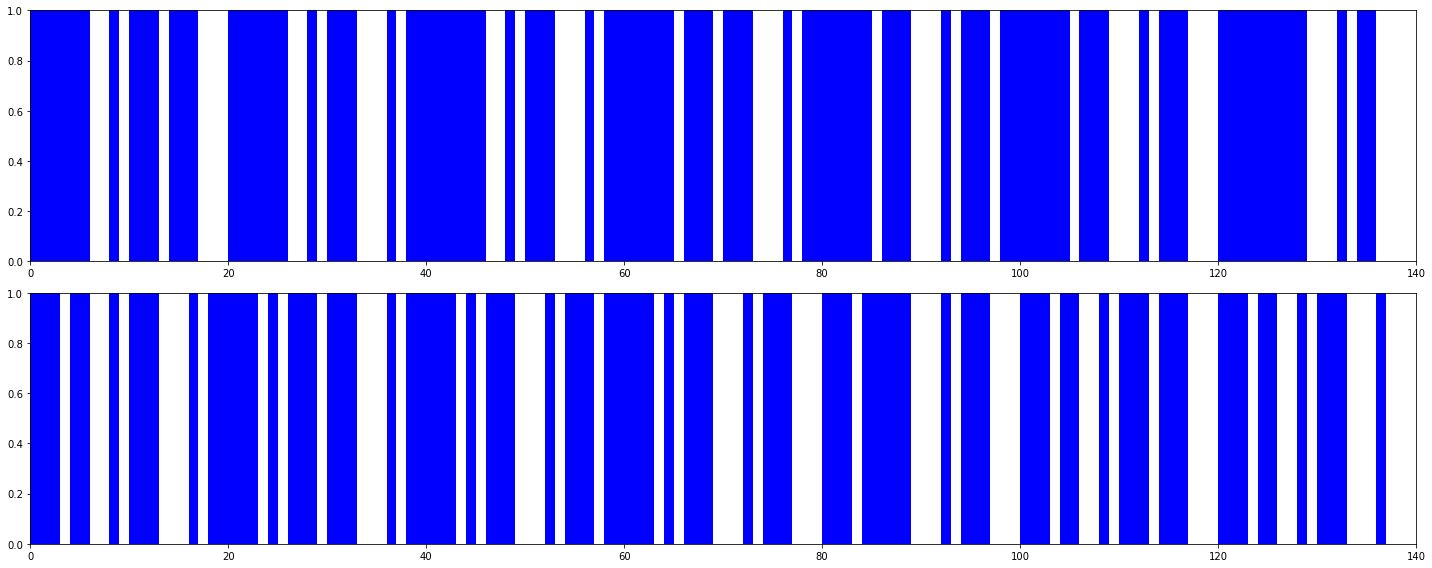

In [150]:
schedule.plotSchedule()